### Hands On Session: Dataset Engineering

### By Adi Nair, Anderson lab

In this section, we'll examine some common problems in datasets that hinders classification and other tasks and think of ways to fix them. We'll use the same dataset as before from [Remedios et al., 2017](https://https://www.nature.com/articles/nature23885) 

### Table of contents

#### 1) Chance calculation in datasets
Creating null distributions for model performance in datasets

#### 2) Class imbalances
Using resampling and shuffling to overcome class imbalances

#### 3) Data quality checks: Smoothing
Defining metrics to evaluate the quality of recordings in datasets



[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/blob/main/07_05_22_day1_overview/code/solutions/solution_dataset_engineering.ipynb)

In [24]:
# Import neccessary modules and helper functions
# Need to delete unused packages

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from matplotlib import image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale 
from sklearn.utils import shuffle

import imblearn

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    

### Load data

Just as before let's load this dataset

In [25]:


!wget https://raw.githubusercontent.com/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/main/data/hypothalamus_calcium_imaging_remedios_et_al.mat?raw=true
!mv hypothalamus_calcium_imaging_remedios_et_al.mat\?raw\=true hypothalamus_calcium_imaging_remedios_et_al.mat

remedios_data = loadmat("hypothalamus_calcium_imaging_remedios_et_al.mat");
neural_data = remedios_data['neural_data']
attack_vector = remedios_data['attack_vector']
sex_vector = remedios_data['sex_vector']


### 1) Chance calculation in datasets

We've previously seen that training a simple linear model to classify attack frames in this dataset fails due to the rarity of the attack label. But how bad did our models do?

We need to establish a baseline performance or chance-level performance as a lower bound for what we might expect our model to achieve. 

A simple way to do this is by shuffling our behavior vector independently of our neural activity matrix and using that shuffled vector for classification. This needs to be performed a finite number of times to estimate true chance performance.

#### Shuffle attack_vector below and use that shuffled vector to perform simple linear classification below:

In [ ]:
# Enter code here:

Text(0.5, 1.0, 'regression test performance for attack')

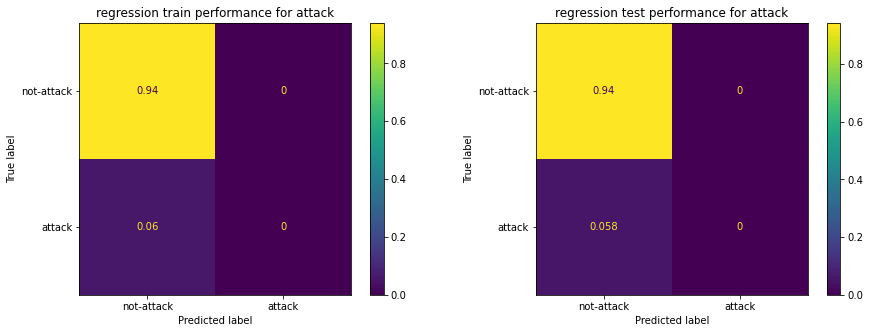

In [52]:
# Solution

y_shuffle =shuffle(attack_vector[0,])

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    y_shuffle.T,
                                                    test_size=0.33, 
                                                    shuffle = False,
                                                    random_state=42)
# perform linear regression
reg = LinearRegression().fit(X_train, y_train)

# Training performance:
train_y_pred = reg.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = reg.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')



#### Observe that even by chance, we can classify all 'not-attack' labels correctly 90% of the time! While that for attack by chance is around 0%.

If you ignored class-wise performance metrics, you can see why an average performance underestimates greatly the performance for classifying attack. 

There are also other important considerations for making a proper chance calculation for neural data that can be taken at the level of experimental design. [Harris 2022](https://www.biorxiv.org/content/10.1101/2020.11.29.402719v3#) is a great read on this topic and you'll encounter this tomorrow with Ann Kennedy

So, how can we account for the sparsity of the attack label?

### 2) Class imbalance

One method that allows us to fix this problem is to resample our dataset so that there are equal numbers of attack and non-attack labels. Resampling techniques are a broad class of tools that allow either random oversampling of the sparse label ('attack') or random undersampling of the majority label ('not-attack').

Python once again has an easy method to implement this in the form of the [imbalanced-learn](https://imbalanced-learn.org/stable/user_guide.html) library.

#### Let's first perform random undersampling using [RandomUnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) and then make a PCA plot using the resampled data below:

#### P.S You can also implement this manually! Try that out too below:

In [ ]:
# Enter code here using imbalance-learn:

In [ ]:
# Enter code for manual implementation here:

In [5]:
# Solution for manual implementation:

atk_idx = np.where(attack_vector[0,] == 1)
nonatk_idx = np.where(attack_vector[0,] == 0)

newnonatk_idx = np.random.choice(nonatk_idx[0],atk_idx[0].shape[0])

new_X = np.concatenate((neural_data[:,atk_idx[0]],neural_data[:,newnonatk_idx]), axis=1)
new_y = np.concatenate((np.ones(atk_idx[0].shape[0]),np.zeros(atk_idx[0].shape[0])), axis=0)


Text(0.05, 0.03, 'attack')

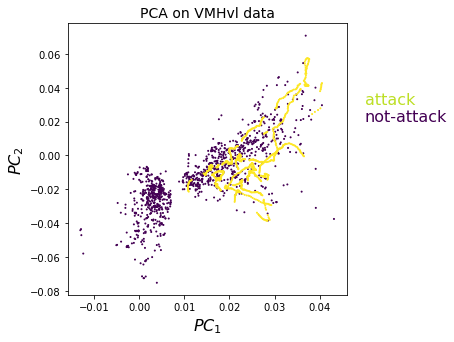

In [45]:
# Solution using imbalance-learn

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(neural_data.T, attack_vector[0,].T)

# perform PCA
pca_neural = PCA(n_components=2)
pca_neural.fit_transform (X_rus.T)
neural_pcs = pca_neural.components_

# plot PCA, colored by intruder sex
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
cmap = matplotlib.cm.get_cmap('viridis')

# neural_pcs.shape
ax.scatter(neural_pcs[0,],neural_pcs[1,], c = y_rus, s = 1)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.05,0.02,'not-attack',color = cmap(0.0),fontsize=16)
ax.text(0.05,0.03,'attack',color = cmap(0.9),fontsize=16)

#### Great! As you can see, the resampled data contains an equal amount of attack and not-attack labels. Train a simple linear model below to seperate data in the resampled case

In [ ]:
# Enter code here

Text(0.5, 1.0, 'regression test performance for attack')

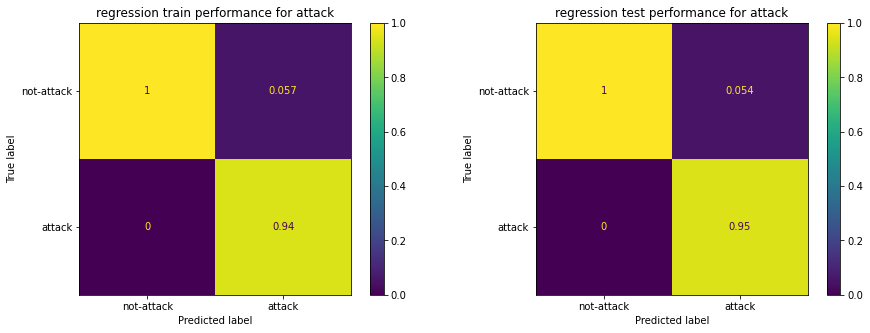

In [46]:
# Solution (regression)

# Solution
# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(X_rus, 
                                                    y_rus.T,
                                                    test_size=0.33, 
                                                    shuffle = True,
                                                    random_state=42)
# perform linear regression
reg = LinearRegression().fit(X_train, y_train)

# Training performance:
train_y_pred = reg.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = reg.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


#### Clearly, resampling helps and our model performance has greatly improved for the attack label! 

But what about the baseline or chance level performance of our model after resampling? 

Would the chance performance of the attack label still be zero? 

#### Calculate a shuffled performance for the resampled case above 

Text(0.5, 1.0, 'regression test performance for attack')

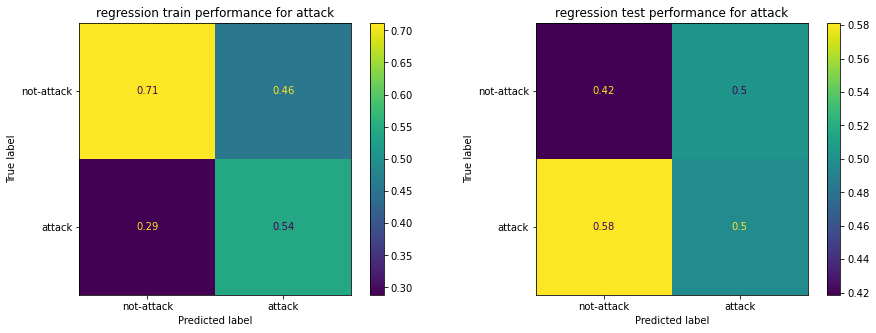

In [53]:
# Solution

# generate test split as last 1/3rd of data
y_shuffle_rus =shuffle(y_rus)

X_train, X_test, y_train, y_test = train_test_split(X_rus, 
                                                    y_shuffle_rus.T,
                                                    test_size=0.33, 
                                                    shuffle = True,
                                                    random_state=42)
# perform linear regression
reg = LinearRegression().fit(X_train, y_train)

# Training performance:
train_y_pred = reg.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = reg.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


#### Thus, about 50% of the time, out model would accurately classify attack. Since our model performance (>90%) is much greater than the chance performance, we can be confident that the linear model has learnt to distinguish attack from not-attack labels

### 2 b) Other resampling approaches

Besides random-undersampling, several other undersampling approaches can be easily implemented using imblearn, find out more about that [here](https://imbalanced-learn.org/stable/references/under_sampling.html)

Most deep learning packages such as PyTorch contain functions to perform resampling in their specified data structures but packages like imblearn are general purpose and are useful in many non deep learning scenarios

### 3) Data quality checks: Smoothing data

When dealing with neural data, it's also important to assess data quality such as noise levels in your recording. Many data pre-processing pipelines (such as kilosort for electrophysiology data and CNMFe for calcium imaging data) already perform checks on data quality but in this exercise we'll think about how to identify corrupted or noisy data.


### Load noisy dataset

#### Some neurons appear especially noisy, can you define a metric that identifies which neurons have more noise than others?

In [54]:
# Enter code here:

### 3 a) Moving average filter

 A simple method to smooth data is to average data in time bins, this can be written as:
 $y(i)  = 1/M \sum_{j = 0}^{M-1} x(i+j)$

#### Implement moving average as a function below:

In [ ]:
# Enter code here:

def smoothMA(a,WSZ):
    # a: NumPy 1-D or 2-D array containing the data to be smoothed (row-wise)
    # WSZ: smoothing window size needs, which must be odd number

    return aSm;

In [ ]:
# Solution

def smoothMA(a,WSZ):
    # a: NumPy 1-D or 2-D array containing the data to be smoothed (row-wise)
    # WSZ: smoothing window size needs, which must be odd number
    aSm = np.zeros(a.shape);
    if(len(a.shape)==1):
        out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ;
        r = np.arange(1,WSZ-1,2);
        start = np.cumsum(a[:WSZ-1])[::2]/r;
        stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1];
        aSm = np.concatenate((  start , out0, stop  ));
    else:
        for i in range(0,a.shape[0]):
            out0 = np.convolve(a[i,:],np.ones(WSZ,dtype=int),'valid')/WSZ;
            r = np.arange(1,WSZ-1,2);
            start = np.cumsum(a[i,:WSZ-1])[::2]/r;
            stop = (np.cumsum(a[i,:-WSZ:-1])[::2]/r)[::-1];
            aSm[i,:] = np.concatenate((  start , out0, stop  ));
    return aSm;

#### Use the moving average filter you defined to smooth neural activity for identified neurons by

In [ ]:
# Enter code here